In [1]:
%config Completer.use_jedi = False
import numpy as np
import numba

from matplotlib import pyplot as plt

In [33]:
@numba.jit(nopython=True)
def integrate(c0, t, dt, n, L, Ds, f, f_args):    
    t_c = t[0]
    c_c = c0.copy()
    dc = np.zeros_like(c_c)
    d_ret = np.zeros((c0.shape[0], c0.shape[1], c0.shape[2], t.shape[0]))
    d_ret[:, :, :, 0] = c_c.copy()  
    c_num = c0.shape[0]
    n_2 = (n[0]-1)*(n[1]-1)
    for t_i, t_next in enumerate(t[1:]):        
        while t_c < t_next:
            f_f = f(c_c, t_c, f_args)
            for i in range(n[0]):
                for j in range(n[1]):
                    # Periodic boundary condition
                    i_prev = (i-1)%n[0]
                    i_next = (i+1)%n[0]

                    j_prev = (j-1)%n[1]
                    j_next = (j+1)%n[1]
                    for k in range(c_num):
                        dc[k, i, j] = (Ds[k]*n_2)*(c_c[k, i_prev, j]+c_c[k, i_next, j] + \
                                             c_c[k, i, j_prev]+c_c[k, i, j_next] - 4.0*c_c[k, i, j]) \
                                           + f_f[k, i, j]
                                      
            
            c_c += dt*dc        
            t_c += dt
        d_ret[:, :, :, t_i+1] = c_c.copy()
    return d_ret
        

In [34]:
@numba.jit(nopython=True)
def f(c, t, f_args):
    alpha, epsilon, mu = f_args
    u = c[0, :, :]
    v = c[1, :, :]        
    fu = -epsilon*alpha*u + epsilon*v
    fv = -u + mu*v - v*v*v
    return np.stack((fu, fv))

In [48]:
n = (32, 32)
L = (1.0, 1.0)

c0 = np.random.normal(scale=0.01, size=(2, n[0], n[1]))

Ds = np.array([0.05, 0.00028])
alpha = 1.0
epsilon = 6.45#6.0
mu = 1.5#1.4

f_args = (alpha, epsilon, mu)
t = np.linspace(0, 2000, 100)

dt = 0.001

sol = integrate(c0, t, dt, n, L, Ds, f, f_args)


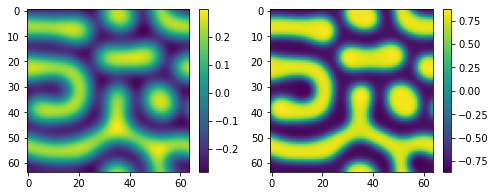

In [46]:
_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(sol[0,:,:, -1])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(sol[1,:,:, -1])
plt.colorbar(shrink=.75)

In [ ]:
with open('../turing_FitzHugh_Nagumo.npy', 'wb') as f:
    np.save(f, sol)
    
with open('../turing_t_FitzHugh_Nagumo.npy', 'wb') as f:
    np.save(f, t)

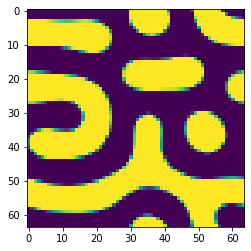

In [47]:
from matplotlib.animation import FuncAnimation


fig = plt.figure()

im = im=plt.imshow(sol[0, :,:,0])#  ,interpolation='none')
def init():
    im.set_data(sol[0, :,:,0])
    return [im]
    
def animate(i):    
    a=im.get_array()
    a=sol[0, :,:,i] 
    im.set_array(sol[0, :,:,i] )
    return [im]

anim = FuncAnimation(fig, animate, init_func=init,
                               frames=len(t), interval=100, blit=True)


anim.save('turring_FitzHugh_Nagumo.gif', writer='imagemagick')